# 02_train_timegan.ipynb

**Goal**: This is my first attempt to train the TimeGAN model to produce quality synthetic data.


**Result**: After multiple rounds of calibration, the output (as showcased by the plots at the very end), the generator discovers a few "safe" outputs that can consistently fool the discriminator. It then stops exploring and only produces this limited variety of samples, failing to capture the rich diversity of the real data. The unnaturally smooth, flat-lining plots are a clear sign of this problem. ***This is a telltale sign of [mode collapse.](https://en.wikipedia.org/wiki/Mode_collapse)***

**Way Forward**: I propose a two-pronged approach. Firstly, I will introduce regularization to the discriminator. This noise/dropout forces the discriminator to learn more robust features. Secondly, I will increased the model capacity by doubling the `LATENT_DIM` to 48, thereby giving it more room to learn.

In [ ]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

# Import our custom modules
from generative_finance.models import (
    build_autoencoder, 
    build_generator, 
    build_discriminator
)
from generative_finance.training import TimeGANTrainer

## 1. Configuration

In [7]:
# Select which stock to train on
TICKER = 'AAPL'

# Model Hyperparameters
SEQ_LEN = 24
FEATURE_DIM = 1 # We are using a univariate time series (Adj Close price)
LATENT_DIM = 24 # Dimensionality of the latent space
NUM_LAYERS = 2  # Number of GRU layers in the models

# Training Hyperparameters
EPOCHS = 500 # Total number of training epochs
BATCH_SIZE = 128
LEARNING_RATES = {
    'autoencoder': 0.001,
    'supervisor': 0.001,
    'gan': {
        'generator': 0.001,      # Keep generator's LR high
        'discriminator': 0.00001 # Decrease discriminator's LR further
    }
}

print("--- Configuration Loaded ---")
print(f"Target Ticker: {TICKER}")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Epochs: {EPOCHS}")

--- Configuration Loaded ---
Target Ticker: AAPL
Latent Dimension: 24
Epochs: 500


## 2. Load Pre-processed Data

In [8]:
try:
    data_path = f'data/processed/{TICKER}_data.npy'
    scaler_path = f'data/processed/{TICKER}_scaler.joblib'
    
    # Load the numpy array and the scaler
    data = np.load(data_path)
    scaler = joblib.load(scaler_path)
    
    print(f"\n--- Data Loaded Successfully ---")
    print(f"Data shape: {data.shape}")
    
except FileNotFoundError:
    print(f"Error: Data for ticker {TICKER} not found. Please run the data preparation notebook first.")
    exit()



--- Data Loaded Successfully ---
Data shape: (2614, 24, 1)


## 3. Build the TimeGAN Models

In [9]:
encoder, recovery = build_autoencoder(SEQ_LEN, LATENT_DIM, FEATURE_DIM)
generator = build_generator(SEQ_LEN, LATENT_DIM)
discriminator = build_discriminator(SEQ_LEN, LATENT_DIM)

models = {
    'encoder': encoder,
    'recovery': recovery,
    'generator': generator,
    'discriminator': discriminator
}

print("\n--- Models Built Successfully ---")
models['discriminator'].summary()



--- Models Built Successfully ---


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                    │ (None, 24, 24)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ (None, 24)             │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,225 (28.22 KB)

 Trainable params: 7,225 (28.22 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Initialize and Run the Trainer

In [10]:
trainer = TimeGANTrainer(
    models=models,
    latent_dim=LATENT_DIM,
    learning_rates=LEARNING_RATES
)

print("\n--- Starting Model Training ---")
# This will begin the epoch-by-epoch training process
trainer.train(
    data=data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    g_train_steps=5  # Increase this value
)

print("\n--- Training Complete ---")


--- Starting Model Training ---
Epoch: 0, E_loss: 0.2081, G_loss_S: 0.2244, G_loss_U: 0.7408, D_loss: 1.3371
Epoch: 10, E_loss: 0.0317, G_loss_S: 0.1168, G_loss_U: 0.7045, D_loss: 1.3901
Epoch: 20, E_loss: 0.0109, G_loss_S: 0.1180, G_loss_U: 0.7996, D_loss: 1.2339
Epoch: 30, E_loss: 0.0086, G_loss_S: 0.1273, G_loss_U: 0.8942, D_loss: 1.0918
Epoch: 40, E_loss: 0.0076, G_loss_S: 0.1336, G_loss_U: 0.9430, D_loss: 0.9802
Epoch: 50, E_loss: 0.0061, G_loss_S: 0.1419, G_loss_U: 1.0122, D_loss: 0.8624
Epoch: 60, E_loss: 0.0049, G_loss_S: 0.1437, G_loss_U: 1.1435, D_loss: 0.7375
Epoch: 70, E_loss: 0.0050, G_loss_S: 0.1468, G_loss_U: 1.2610, D_loss: 0.6604
Epoch: 80, E_loss: 0.0055, G_loss_S: 0.1511, G_loss_U: 1.3749, D_loss: 0.5757
Epoch: 90, E_loss: 0.0064, G_loss_S: 0.1553, G_loss_U: 1.4366, D_loss: 0.4887
Epoch: 100, E_loss: 0.0060, G_loss_S: 0.1548, G_loss_U: 1.6217, D_loss: 0.4269
Epoch: 110, E_loss: 0.0035, G_loss_S: 0.1602, G_loss_U: 1.7484, D_loss: 0.3450


2025-07-05 08:44:52.102255: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 120, E_loss: 0.0039, G_loss_S: 0.1645, G_loss_U: 1.7757, D_loss: 0.3306
Epoch: 130, E_loss: 0.0045, G_loss_S: 0.1622, G_loss_U: 2.0103, D_loss: 0.2730
Epoch: 140, E_loss: 0.0035, G_loss_S: 0.1672, G_loss_U: 2.1854, D_loss: 0.1984
Epoch: 150, E_loss: 0.0027, G_loss_S: 0.1649, G_loss_U: 2.6021, D_loss: 0.1729
Epoch: 160, E_loss: 0.0036, G_loss_S: 0.1635, G_loss_U: 2.4248, D_loss: 0.1675
Epoch: 170, E_loss: 0.0025, G_loss_S: 0.1659, G_loss_U: 2.6281, D_loss: 0.1310
Epoch: 180, E_loss: 0.0046, G_loss_S: 0.1630, G_loss_U: 3.0077, D_loss: 0.0982
Epoch: 190, E_loss: 0.0031, G_loss_S: 0.1644, G_loss_U: 3.3739, D_loss: 0.0808
Epoch: 200, E_loss: 0.0034, G_loss_S: 0.1692, G_loss_U: 3.4014, D_loss: 0.0648
Epoch: 210, E_loss: 0.0031, G_loss_S: 0.1647, G_loss_U: 3.5136, D_loss: 0.0565
Epoch: 220, E_loss: 0.0032, G_loss_S: 0.1679, G_loss_U: 3.6793, D_loss: 0.0503
Epoch: 230, E_loss: 0.0017, G_loss_S: 0.1642, G_loss_U: 3.8851, D_loss: 0.0453
Epoch: 240, E_loss: 0.0019, G_loss_S: 0.1703, G_loss

2025-07-05 08:53:39.209673: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 370, E_loss: 0.0026, G_loss_S: 0.1658, G_loss_U: 5.7444, D_loss: 0.0074
Epoch: 380, E_loss: 0.0017, G_loss_S: 0.1675, G_loss_U: 5.9385, D_loss: 0.0064
Epoch: 390, E_loss: 0.0021, G_loss_S: 0.1629, G_loss_U: 5.9307, D_loss: 0.0060
Epoch: 400, E_loss: 0.0013, G_loss_S: 0.1579, G_loss_U: 6.1308, D_loss: 0.0055
Epoch: 410, E_loss: 0.0013, G_loss_S: 0.1625, G_loss_U: 6.3017, D_loss: 0.0047
Epoch: 420, E_loss: 0.0022, G_loss_S: 0.1649, G_loss_U: 6.2330, D_loss: 0.0045
Epoch: 430, E_loss: 0.0016, G_loss_S: 0.1611, G_loss_U: 6.3253, D_loss: 0.0043
Epoch: 440, E_loss: 0.0031, G_loss_S: 0.1595, G_loss_U: 6.4550, D_loss: 0.0038
Epoch: 450, E_loss: 0.0022, G_loss_S: 0.1634, G_loss_U: 6.5060, D_loss: 0.0036
Epoch: 460, E_loss: 0.0014, G_loss_S: 0.1609, G_loss_U: 6.4236, D_loss: 0.0036
Epoch: 470, E_loss: 0.0019, G_loss_S: 0.1619, G_loss_U: 6.5498, D_loss: 0.0032
Epoch: 480, E_loss: 0.0031, G_loss_S: 0.1620, G_loss_U: 6.6779, D_loss: 0.0029
Epoch: 490, E_loss: 0.0029, G_loss_S: 0.1665, G_loss


## 5. Generate Synthetic Data (Post-Training)

In [12]:
print("\n--- Starting Synthetic Data Generation ---")

# Define the number of synthetic samples to generate
num_samples_to_generate = 500

# 1. Generate random noise sequences
random_noise = tf.random.normal(shape=(num_samples_to_generate, SEQ_LEN, LATENT_DIM))

# 2. Use the generator to create synthetic sequences in the latent space
generated_data_latent = models['generator'].predict(random_noise)
print(f"Shape of generated latent data: {generated_data_latent.shape}")

# 3. Use the recovery model to convert from latent space to real (scaled) space
# This is the crucial missing step.
generated_data_scaled = models['recovery'].predict(generated_data_latent)
print(f"Shape of recovered (scaled) data: {generated_data_scaled.shape}")

# 4. Reshape the data for the scaler
# The scaler expects a 2D array: (total_timesteps, features)
generated_data_reshaped = generated_data_scaled.reshape(-1, FEATURE_DIM)

# 5. Inverse transform the data to get the real price scale
synthetic_data = scaler.inverse_transform(generated_data_reshaped)

# 6. Reshape the final data back into sequences
synthetic_data = synthetic_data.reshape(num_samples_to_generate, SEQ_LEN, FEATURE_DIM)

print("\n--- Synthetic Data Generation Complete ---")
print(f"Final shape of synthetic data: {synthetic_data.shape}")


--- Starting Synthetic Data Generation ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Shape of generated latent data: (500, 24, 24)
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of recovered (scaled) data: (500, 24, 1)

--- Synthetic Data Generation Complete ---
Final shape of synthetic data: (500, 24, 1)


## 6. Plots

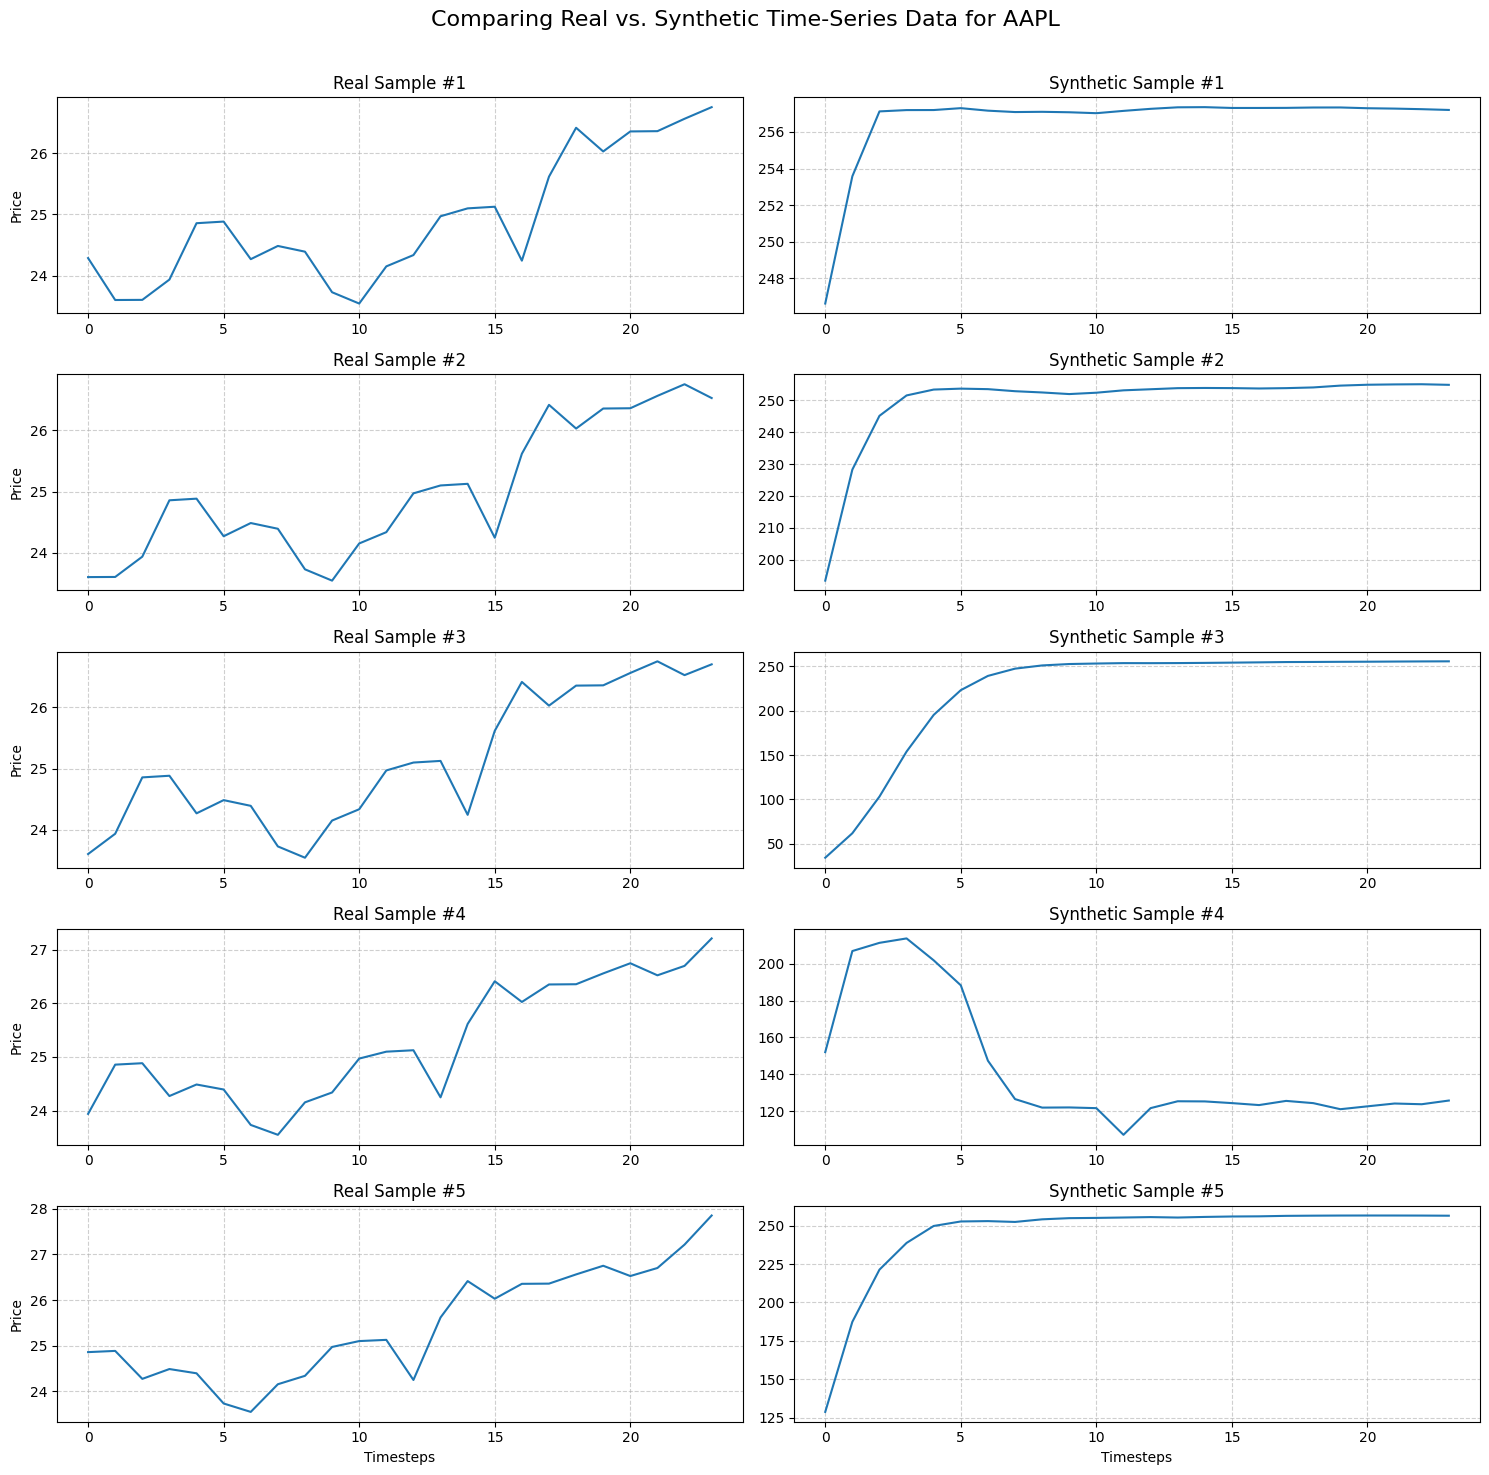

In [15]:
# -- 1. Configuration --
# Number of sample sequences to plot
num_to_plot = 5

# -- 2. Select Real and Synthetic Samples --
# Select the first few synthetic samples
synthetic_samples = synthetic_data[:num_to_plot]

# Select the first few real samples from the original pre-processed data
real_samples_scaled = data[:num_to_plot]

# -- 3. Inverse Transform the Real Samples to Original Price Scale --
# Reshape for the scaler
real_samples_reshaped = real_samples_scaled.reshape(-1, FEATURE_DIM)

# Inverse transform
real_samples_unscaled = scaler.inverse_transform(real_samples_reshaped)

# Reshape back to sequences
real_samples = real_samples_unscaled.reshape(num_to_plot, SEQ_LEN, FEATURE_DIM)


# -- 4. Create the Plots --
fig, axes = plt.subplots(nrows=num_to_plot, ncols=2, figsize=(15, num_to_plot * 3))
fig.suptitle(f'Comparing Real vs. Synthetic Time-Series Data for {TICKER}', fontsize=16)

for i in range(num_to_plot):
    # Plot Real Data
    axes[i, 0].plot(real_samples[i])
    axes[i, 0].set_title(f'Real Sample #{i + 1}')
    axes[i, 0].set_ylabel('Price')
    axes[i, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot Synthetic Data
    axes[i, 1].plot(synthetic_samples[i])
    axes[i, 1].set_title(f'Synthetic Sample #{i + 1}')
    axes[i, 1].grid(True, linestyle='--', alpha=0.6)

# Add x-axis labels to the last row only
axes[-1, 0].set_xlabel('Timesteps')
axes[-1, 1].set_xlabel('Timesteps')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()